In [1]:
import sys
import math

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as stats

from mpengine import mpPandasObj
from tqdm import tqdm, tqdm_notebook
from multiprocessing import cpu_count

from util import cprintf
from sample_weights import mpNumCoEvents, mpSampleTW
from financial_data_structures import returns
from labeling import getDailyVol, getTEvents, addVerticalBarrier, getEvents

%matplotlib inline

In [2]:
df = pd.read_csv('data/dollar_bars.csv', index_col='dates').drop_duplicates()
df.index = pd.to_datetime(df.index)


In [3]:
close = df.price.copy()
close = close[~close.index.duplicated(keep='first')]
cprintf(close)

dailyVol = getDailyVol(close, 17)


-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                      price
dates                      
2018-07-23 12:57:57  7712.4
2018-07-23 13:24:42  7715.3
2018-07-23 14:18:39  7707.7
2018-07-23 14:56:24  7701.8
2018-07-23 15:31:40  7719.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701 entries, 2018-07-08 22:27:05 to 2018-07-23 15:31:40
Data columns (total 1 columns):
price    701 non-null float64
dtypes: float64(1)
memory usage: 11.0 KB
None
-------------------------------------------------------------------------------


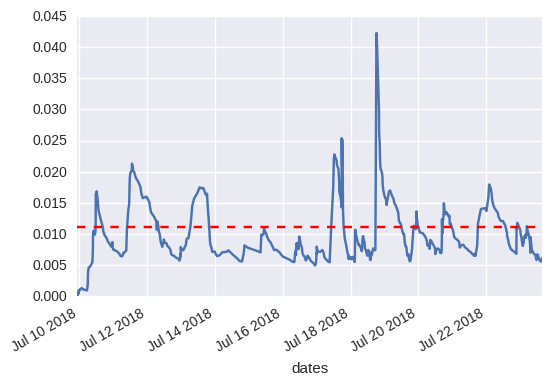

In [4]:
f,ax = plt.subplots()
dailyVol.plot(ax=ax)
ax.axhline(dailyVol.mean(), ls='--', color='r')

In [5]:
tEvents = getTEvents(close, h = dailyVol.mean())
#cprintf(tEvents)

t1 = addVerticalBarrier(tEvents, close)
cprintf(t1)

  0%|          | 0/699 [00:00<?, ?it/s]100%|██████████| 699/699 [00:00<00:00, 9994.00it/s]

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                                  dates
2018-07-22 00:20:03 2018-07-23 00:20:38
2018-07-22 02:44:05 2018-07-23 02:47:47
2018-07-22 05:43:42 2018-07-23 05:46:28
2018-07-22 13:24:30 2018-07-23 13:24:42
2018-07-22 15:23:27 2018-07-23 15:31:40
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145 entries, 2018-07-09 07:46:12 to 2018-07-22 15:23:27
Data columns (total 1 columns):
dates    145 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.3 KB
None
-------------------------------------------------------------------------------


In [6]:
ptSl = [1,1]
target = dailyVol
minRet = 0.01
cpus = cpu_count() - 1

events = getEvents(close, tEvents, ptSl, target, minRet, cpus, t1=t1)

labeling.py:91: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  trgt = trgt.loc[tEvents]
2018-09-02 03:07:40.339513 66.67% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes.2018-09-02 03:07:40.340875 100.0% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes.


In [7]:
numThreads = cpu_count()
numCoEvents = mpPandasObj(mpNumCoEvents, ('molecule', events.index), numThreads, closeIdx = close.index, t1 = events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)
cprintf(numCoEvents)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                       0
dates                   
2018-07-23 12:57:57  0.0
2018-07-23 13:24:42  0.0
2018-07-23 14:18:39  0.0
2018-07-23 14:56:24  0.0
2018-07-23 15:31:40  0.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701 entries, 2018-07-08 22:27:05 to 2018-07-23 15:31:40
Data columns (total 1 columns):
0    701 non-null float64
dtypes: float64(1)
memory usage: 31.0 KB
None
-------------------------------------------------------------------------------


2018-09-02 03:07:41.650289 100.0% mpNumCoEvents done after 0.0 minutes. Remaining 0.0 minutes.


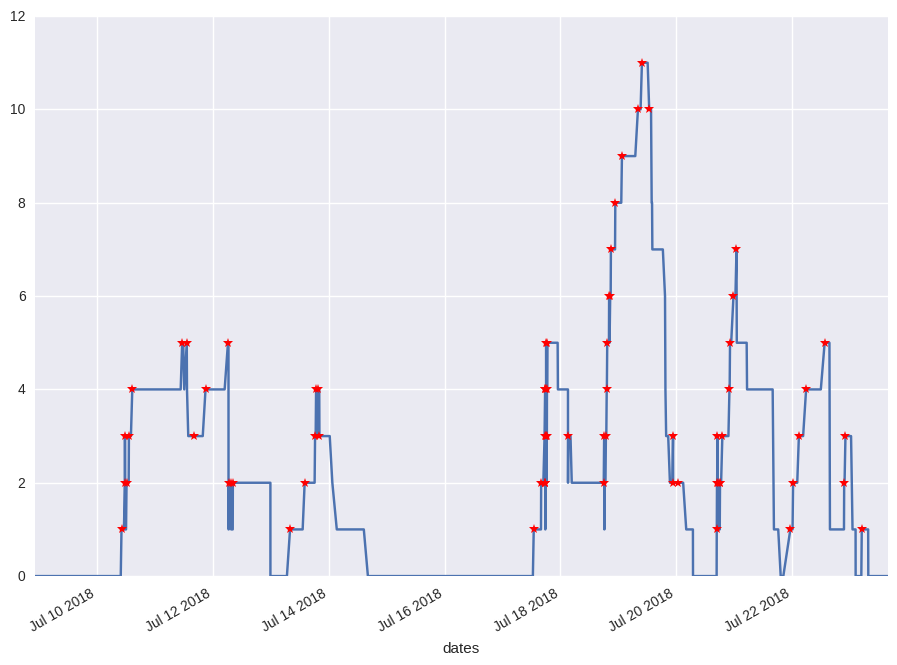

In [8]:
f, ax = plt.subplots(figsize=(11,8))
numCoEvents.plot(ax=ax)

label = numCoEvents.loc[events.index]
label.plot(ax=ax, ls = '', marker = '*', markersize = 7, color = 'r')

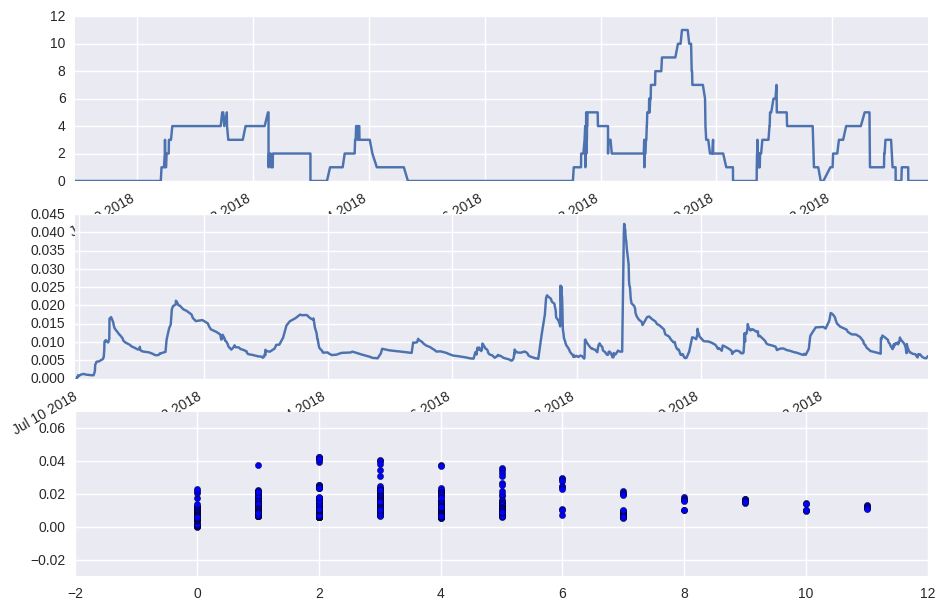

In [9]:
f, ax = plt.subplots(3, figsize=(11,8))
numCoEvents.plot(ax=ax[0])
dailyVol.plot(ax=ax[1])

dailyVol0 = dailyVol[numCoEvents.index]
plt.scatter(x = numCoEvents, y = dailyVol0)


In [41]:
out_tW = mpPandasObj(mpSampleTW, ('molecule', events.index), numThreads, t1 = events['t1'], numCoEvents = numCoEvents)
out_tW.mean()

indM = pd.DataFrame(0, index = [1, 2, 3,], columns = [1,2])

indM.loc[1, 1] = 1
indM.loc[1, 2] = 2

indM.loc[2, 1] = 3
indM.loc[2, 2] = 4

indM.loc[3, 1] = 5
indM.loc[3, 2] = 6

print indM

for i, (t0,t1) in enumerate(indM.iteritems()):
    #print i
    #print t0
    print t1

#c = indM.sum(axis = 1)
#print c

#u = indM.div(c, axis = 0)
#print u

#u.mean()

   1  2
1  1  2
2  3  4
3  5  6
1    1
2    3
3    5
Name: 1, dtype: int64
1    2
2    4
3    6
Name: 2, dtype: int64


2018-09-02 04:05:04.106188 100.0% mpSampleTW done after 0.0 minutes. Remaining 0.0 minutes.
